In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn import preprocessing
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn import metrics

from catboost import CatBoostRegressor
from catboost.utils import eval_metric
from catboost import cv
from catboost import Pool
from sklearn.model_selection import train_test_split
%matplotlib inline
plt.style.use('seaborn')

C:\Users\l-pla\AppData\Local\Temp\ipykernel_9832\606577683.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


#### 1. Загрузка данных

In [56]:
path = r'data\train_data.zip'
data = pd.read_csv(path, compression = 'zip')

In [57]:
data.head(10)

,product_name,period,price,postcode,address_name,lat,lon,object_type,total_square,rooms,floor,city,settlement,district,area,description,source
0,"3-комнатная, 137 м²",NaN,63000000,127473.0,"2-й Щемиловский переулок, 5а",55.778894,37.608844,Квартира,137.0,3.0,6.0,Москва,NaN,Тверской район,NaN,Просторная квартира свободной планировки с пан...,ЦИАН
1,"Студия, 16,7 м²",NaN,3250000,108815.0,"Харлампиева, 46",55.551025,37.313054,Квартира,16.7,NaN,1.0,Москва,NaN,Филимонковское поселение,NaN,ВНИМАНИЕ! ОЧЕНЬ ПРИВЛЕКАТЕЛЬНОЕ ПРЕ...,Домклик
2,"3-комнатная, 76 м²",NaN,16004680,NaN,"ЖК Прокшино, 8 к4",55.594802,37.431264,Квартира,76.0,3.0,6.0,Москва,NaN,Сосенское поселение,NaN,"Apт.1684018. 0,01% - гибкая ипотека! Воспользу...",Яндекс.Недвижимость
3,"1-комнатная, 24 м²",NaN,7841776,NaN,"ЖК Прокшино, 6 к2",55.594332,37.428099,Квартира,24.0,1.0,10.0,Москва,NaN,Сосенское поселение,NaN,Продается однокомнатная квартира № 381 в новос...,Новострой-М
4,"3-комнатная, 126 м²",NaN,120000000,121352.0,"Давыдковская, 18",55.721097,37.464342,Квартира,126.0,3.0,16.0,Москва,NaN,Фили-Давыдково район,NaN,Шикарное предложение!\nПродаётся трёхкомнатная...,Домклик
5,"3-комнатная, 74 м²",NaN,13300000,142721.0,"Пригородное шоссе, 3",55.557342,37.809447,Квартира,74.0,3.0,14.0,NaN,д. Мисайлово,NaN,NaN,Арт. 32494997 \nОтличная 3-х комнатная квартир...,ЦИАН
6,"2-комнатная, 65 м²",NaN,9500000,143986.0,"Автозаводская, 4 к2",55.740408,38.011392,Квартира,65.0,2.0,3.0,Балашиха,NaN,NaN,Железнодорожный м-н,Предлагается к покупке просторная двухкомнатна...,Домклик
7,"3-комнатная, 87 м²",NaN,15000000,143072.0,"Михаила Кутузова, 15",55.659569,37.218370,Квартира,87.0,3.0,11.0,NaN,пос. ВНИИССОК,NaN,NaN,"ЖК Гусарская Баллада, кирпичный дом, огороженн...",ЦИАН
8,"2-комнатная, 35,8 м²",NaN,7135671,NaN,"3-й квартал, к66",55.700571,37.962692,Квартира,35.8,2.0,11.0,Люберцы,NaN,NaN,Самолёт м-н,Продается двухкомнатная квартира № 542 в новос...,Новострой-М
9,"2-комнатная, 68,3 м²",NaN,31500000,127427.0,"улица Академика Королёва, 21",55.820044,37.602498,Квартира,68.3,2.0,4.0,Москва,NaN,Марфино район,NaN,Дом ''Достижение'' располагается в Москве в ок...,ЦИАН


In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98822 entries, 0 to 98821
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_name  98822 non-null  object 
 1   period        0 non-null      float64
 2   price         98822 non-null  int64  
 3   postcode      93675 non-null  float64
 4   address_name  98821 non-null  object 
 5   lat           98822 non-null  float64
 6   lon           98822 non-null  float64
 7   object_type   98822 non-null  object 
 8   total_square  98822 non-null  float64
 9   rooms         94840 non-null  float64
 10  floor         98822 non-null  float64
 11  city          91928 non-null  object 
 12  settlement    6894 non-null   object 
 13  district      75111 non-null  object 
 14  area          19498 non-null  object 
 15  description   98573 non-null  object 
 16  source        98822 non-null  object 
dtypes: float64(7), int64(1), object(9)
memory usage: 12.8+ MB


#### 2. Очистка данных и заполнение пропусков


In [59]:
# Выведем список признаков с прокусками отсортированный по возрастанию количества пропусков 

def series_cols_with_null (df: pd.DataFrame) -> pd.Series:
    cols_null_percent = df.isnull().mean() * 100
    cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
    return cols_with_null

In [60]:
series_cols_with_null(data)

period          100.000000
settlement       93.023821
area             80.269576
district         23.993645
city              6.976179
postcode          5.208354
rooms             4.029467
description       0.251968
address_name      0.001012
dtype: float64

##### 2.1. Удалим признаки period

In [61]:
# Удалим признак period тк в нем нет информации
data.drop(columns = ['period'], axis = 1, inplace = True)

##### Заполним пропуски в признаках city и district

In [62]:
# Отфильтруем таблицу, чтобы вывести все строки с пропусками в признаке city
data[data.city.isna()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6894 entries, 5 to 98815
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_name  6894 non-null   object 
 1   price         6894 non-null   int64  
 2   postcode      6508 non-null   float64
 3   address_name  6894 non-null   object 
 4   lat           6894 non-null   float64
 5   lon           6894 non-null   float64
 6   object_type   6894 non-null   object 
 7   total_square  6894 non-null   float64
 8   rooms         6130 non-null   float64
 9   floor         6894 non-null   float64
 10  city          0 non-null      object 
 11  settlement    6894 non-null   object 
 12  district      1045 non-null   object 
 13  area          2254 non-null   object 
 14  description   6894 non-null   object 
 15  source        6894 non-null   object 
dtypes: float64(6), int64(1), object(9)
memory usage: 915.6+ KB


In [63]:
# Отфильтруем таблицу, чтобы вывести все строки с пропусками в признаке district
data[data.district.isna()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23711 entries, 5 to 98815
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_name  23711 non-null  object 
 1   price         23711 non-null  int64  
 2   postcode      23008 non-null  float64
 3   address_name  23710 non-null  object 
 4   lat           23711 non-null  float64
 5   lon           23711 non-null  float64
 6   object_type   23711 non-null  object 
 7   total_square  23711 non-null  float64
 8   rooms         22060 non-null  float64
 9   floor         23711 non-null  float64
 10  city          17862 non-null  object 
 11  settlement    5849 non-null   object 
 12  district      0 non-null      object 
 13  area          16239 non-null  object 
 14  description   23711 non-null  object 
 15  source        23711 non-null  object 
dtypes: float64(6), int64(1), object(9)
memory usage: 3.1+ MB


Заметим, что в исходном наборе данных квартиры расположенные в населенном пункте не дублирутся в признак city и наоборот. Похожая картина и у пизнаков district и area.

Объединим признаки city и settlement в один признак city.  
Также объединим признаки district и area в один признак district.


In [64]:
data['city'] = data['city'].fillna(data['settlement'])
data['district'] = data['district'].fillna(data['area'])

In [65]:
# Отфильтруем таблицу, чтобы вывести все строки с пропусками в признаке district
data[data.district.isna()]

,product_name,price,postcode,address_name,lat,lon,object_type,total_square,rooms,floor,city,settlement,district,area,description,source
5,"3-комнатная, 74 м²",13300000,142721.0,"Пригородное шоссе, 3",55.557342,37.809447,Квартира,74.0,3.0,14.0,д. Мисайлово,д. Мисайлово,NaN,NaN,Арт. 32494997 \nОтличная 3-х комнатная квартир...,ЦИАН
7,"3-комнатная, 87 м²",15000000,143072.0,"Михаила Кутузова, 15",55.659569,37.218370,Квартира,87.0,3.0,11.0,пос. ВНИИССОК,пос. ВНИИССОК,NaN,NaN,"ЖК Гусарская Баллада, кирпичный дом, огороженн...",ЦИАН
35,"2-комнатная, 54 м²",10260000,140060.0,"Ленинградская, 15",55.607467,37.980339,Квартира,54.0,2.0,2.0,рп. Октябрьский,рп. Октябрьский,NaN,NaN,Продам квартиру. Ремонт делали для себя из дор...,Домклик
40,"1-комнатная, 39,2 м²",6600000,143902.0,"улица Советская, 56",55.817534,37.953557,Квартира,39.2,1.0,12.0,Балашиха,NaN,NaN,NaN,"Продается однокомнатная квартира с ремонтом, м...",Домклик
48,"3-комнатная, 86,5 м²",14400000,141207.0,"Писаревская, 5",56.008364,37.842638,Квартира,86.5,3.0,12.0,Пушкино,NaN,NaN,NaN,Код объекта 2840.\n\nТрёхкомнатная квартира на...,ЦИАН
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98750,"1-комнатная, 40,7 м²",6550000,142715.0,"Римский проезд, 5",55.596843,37.767380,Квартира,40.7,1.0,8.0,пос. Развилка,пос. Развилка,NaN,NaN,Квартира подходит под рассрочку КУПИ СЕЙЧАС ПЛ...,Домклик
98759,"2-комнатная, 57,9 м²",10065081,142715.0,"посёлок Развилка, к7",55.598270,37.769267,Квартира,57.9,2.0,1.0,пос. Развилка,пос. Развилка,NaN,NaN,Продается двухкомнатная квартира № 72 в новост...,Новострой-М
98765,"2-комнатная, 42 м²",5750000,141280.0,"Студенческий проезд, 40",55.980706,37.908912,Квартира,42.0,2.0,2.0,Ивантеевка,NaN,NaN,NaN,Вашему вниманию предлагается 2-х комнатная ква...,Домклик
98814,"1-комнатная, 40 м²",6000000,140060.0,"60 лет Победы, 10а",55.606092,37.965460,Квартира,40.0,1.0,10.0,рп. Октябрьский,рп. Октябрьский,NaN,NaN,"Продается просторная, теплая однокомнатная ква...",Домклик


##### 2.2. Удалим признаки settlement и area

In [66]:
data.drop(columns = ['settlement', 'area'], axis = 1, inplace = True)

In [67]:
# Пропуски в данных
series_cols_with_null(data)

district        7.561069
postcode        5.208354
rooms           4.029467
description     0.251968
address_name    0.001012
dtype: float64

##### 2.3. Заполним оставшиеся пропуски в признаке district

In [68]:
# Заполним пропуски в district сответствующими значениями из признака city
data['district'] = data['district'].fillna(data['city'])

In [69]:
# Пропуски в данных
series_cols_with_null(data)

postcode        5.208354
rooms           4.029467
description     0.251968
address_name    0.001012
dtype: float64

##### 2.4. Заполним пропуски в признаке rooms 

In [70]:
# Отфильтруем таблицу, чтобы вывести все строки с пропусками в признаке rooms
data[data.rooms.isna()]

,product_name,price,postcode,address_name,lat,lon,object_type,total_square,rooms,floor,city,district,description,source
1,"Студия, 16,7 м²",3250000,108815.0,"Харлампиева, 46",55.551025,37.313054,Квартира,16.70,NaN,1.0,Москва,Филимонковское поселение,ВНИМАНИЕ! ОЧЕНЬ ПРИВЛЕКАТЕЛЬНОЕ ПРЕ...,Домклик
52,"Квартира, 40,5 м²",30142700,107078.0,"проспект Академика Сахарова, 11 стр",55.771159,37.643736,Квартира,40.46,NaN,9.0,Москва,Красносельский район,"Продаются апартаменты-студия площадью 40,46 кв...",ЦИАН
101,"Студия, 39,8 м²",7000000,143402.0,"Жуковского, 11",55.815079,37.325758,Квартира,39.80,NaN,10.0,Красногорск,СГШ м-н,Арт. 28312303 Продается замечательная и просто...,Домклик
106,"Студия, 19,9 м²",5200000,143421.0,"Заповедная улица, 10",55.774497,37.235877,Квартира,19.90,NaN,5.0,пос. Ильинское-Усово,пос. Ильинское-Усово,"Студия , отделка от застройщика. Заповедная до...",Домклик
128,"Студия, 19,8 м²",4700000,125476.0,"улица Василия Петушкова, 9",55.837418,37.403679,Квартира,19.80,NaN,1.0,Москва,Южное Тушино район,На Северо-западе Москвы в экологически чис...,Домклик
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98707,"Студия, 28,4 м²",5550000,108815.0,"Жемчужная, 1 к16",55.551251,37.341194,Квартира,28.40,NaN,1.0,пос. Марьино,Филимонковское поселение,МОСКОВСКАЯ ПРОПИСКА!\nПродаётся теплая квартир...,Домклик
98716,"Квартира, 78,2 м²",35000000,119192.0,"Мичуринский проспект, 56",55.695901,37.485901,Квартира,78.20,NaN,45.0,Москва,Раменки район,Продаётся квартира с потрясающими видовыми хар...,ЦИАН
98762,"Студия, 100,1 м²",77500000,125047.0,"2-я Брестская улица, 6",55.770896,37.591538,Квартира,100.10,NaN,10.0,Москва,Тверской район,Предлагается квартира студия в новом жилом ком...,Домклик
98791,"Студия, 170 м²",95000000,127051.0,"Садовая-Сухаревская улица, 10/12",55.772778,37.627077,Квартира,170.00,NaN,4.0,Москва,Мещанский район,Номер лота: 32292. Предлагается просторная дву...,Домклик


Предположение, что пропущенные строки в признаке rooms принадлежат только квартирам-студиям не подтвердилось. 
Посмотрим распределение пропущенных строк признака rooms относительно признака product_name

In [73]:
def relationship_product_name_for_null_rooms(row: str) -> str:
    if 'дия' in row:
        return 'Студия'
    elif 'ира' in row:
        return 'Квартира'

In [75]:
relationship=data[data.rooms.isna()].loc[:,'product_name'].apply(relationship_product_name_for_null_rooms)
relationship.value_counts()

Студия      3330
Квартира     652
Name: product_name, dtype: int64

Cтудий намного больше, чем просто квартир. Будем считать, что студия - это 1 комната, поэтому заменим все пропуски в столбце rooms на 1.0

In [76]:
data['rooms'] = data['rooms'].fillna(1.0)

In [77]:
# Пропуски в данных
series_cols_with_null(data)

postcode        5.208354
description     0.251968
address_name    0.001012
dtype: float64

##### 2.5. Обработка признака postcode        

In [80]:
# Количество уникальных значений в признаке postcode и district
print(data.postcode.nunique())
print(data.district.nunique())

657
397


Обычно индекс привязан к какому-то небольшому району города или к целому поселку. Видим, что число уникальных индексов больше, чем число районов. 
Поэтому хотелось бы заполнить пропуски и закодировать индексы. 

In [87]:
from dadata import Dadata
token = "ba1b5a53929e63258ef351bf3cf1285b36ad97db"
dadata = Dadata(token)

def reverse_geocoding_postcode (coordinates: pd.Series) -> int:
    result = dadata.geolocate(name="address", lat=coordinates.iloc[0], lon=coordinates.iloc[1])
    if len(result)!= 0:
        if result[0]['data']['postal_code'] != None:
            return result[0]['data']['postal_code']
        else: 
            return np.nan
    else: 
        return np.nan

In [88]:
postalcode_none_df = data[data['postcode'].isna()]
postalcode_none_df.shape

(5147, 14)

In [89]:
postalcode_none_df['postcode']  = postalcode_none_df.loc[:,['lat','lon']].apply(reverse_geocoding_postcode, axis = 1)

C:\Users\l-pla\AppData\Local\Temp\ipykernel_9832\307031046.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  postalcode_none_df['postcode']  = postalcode_none_df.loc[:,['lat','lon']].apply(reverse_geocoding_postcode, axis = 1)


product_name       0
price              0
postcode        1646
address_name       0
lat                0
lon                0
object_type        0
total_square       0
rooms              0
floor              0
city               0
district           0
description        0
source             0
dtype: int64

In [105]:
postalcode_none_df.postcode.isna().sum()

1646

К сожалению, не все индексы были определены. Желательно выбрать сервис помощнее.  
Тогда для бейзлайна оставшиеся данные заполним предыдущим или последующим значением

In [109]:
postalcode_none_df.loc[:,'postcode'] = postalcode_none_df.loc[:,'postcode'].fillna(method = 'ffill')
postalcode_none_df.loc[:,'postcode'] = postalcode_none_df.loc[:,'postcode'].fillna(method = 'bfill')
postalcode_none_df.loc[:,'postcode'].isna().sum()

0

Возможно для данной задачи лучшим решением было бы оставить пропуски в данных, так как ориентируемся на деревья...

Заполним пропуски в исходном датафрейме

In [113]:
data.loc[:,'postcode'] = data.loc[:,'postcode'].fillna(postalcode_none_df.loc[:,'postcode'])

In [114]:
# Пропуски в данных
series_cols_with_null(data)

description     0.251968
address_name    0.001012
dtype: float64

При помощи dadata можно было заполнить все пропуски в данных, так как пропусков в координатах нет. Однако, в юесплатной версии количество запросов в сутки ограничего 10к запросами. 

##### 2.6. Обработка признака description 

In [119]:
data.description

0        Просторная квартира свободной планировки с пан...
1                   ВНИМАНИЕ! ОЧЕНЬ ПРИВЛЕКАТЕЛЬНОЕ ПРЕ...
2        Apт.1684018. 0,01% - гибкая ипотека! Воспользу...
3        Продается однокомнатная квартира № 381 в новос...
4        Шикарное предложение!\nПродаётся трёхкомнатная...
                               ...                        
98817    Продаётся 2-комн.квартира площадью 42.00 кв.м ...
98818    С 1 октября повышение цен на 5% на апартаменты...
98819    Продажа идеальной однокомнатной квартиры. Безу...
98820    Новостройка! Евротрешка , две раздельная комна...
98821    !Двушка в бизнес-классе с шикарной планировкой...
Name: description, Length: 98822, dtype: object

Посмотрев на значения ячеек признака description, мне на беглый взгля не удалось выявить какие-либо закономерности в описании. Можно попытаться поработать с данным признаком, но для бейзлайна думаю, это тупиковый путь.

In [120]:
# Удалим признак description
data.drop('description', axis = 1, inplace = True)

##### 2.7. Обработка пропуска address_name

In [ ]:
data.loc[:,'address_name'].isna().sum()

In [122]:
# В признаке address_name всего один пропуск. ЗАполним его предыдущитм значением
data.loc[:,'address_name'] = data.loc[:,'address_name'].fillna(method = 'bfill')

In [124]:
data.loc[:,'address_name'].isna().sum()

0

##### 2.8. Обработка признака product_name

In [134]:
# Создадим новый признак apart_type
data['apart_type'] = data.loc[:,'product_name'].apply(lambda x: x.split()[0].replace(',',''))

In [136]:
# Удалим признак product_name
data.drop('product_name', axis = 1, inplace = True)

##### 2.9. Обработка признака object_type

In [138]:
# Посмотрим количество уникальных значений признака object_type
data.object_type.nunique()

1

In [139]:
# Удалим признак object_type
data.drop('object_type', axis = 1, inplace = True)

##### 2.10. Обработка признаков lat и lon

In [149]:
# Сами по себе признаки lat и lon неинформативны. При помощи данных признаков посчитаем расттояние от центра Москвы
# до интересующего нас объекта недвижимости.

def distance_from_the_center(cols: pd.Series) -> float:
    R = 6372795 # Earth radius on meter
    lat_center_msk = 55.751999
    lon_center_msk = 37.617734
    d_lat = np.radians(cols[0])-np.radians(lat_center_msk)
    d_lon = np.radians(cols[1])-np.radians(lon_center_msk)
    return 2*R*np.arcsin(np.sqrt((np.sin(d_lat/2))**2 + np.cos(np.radians(cols[0]))*
                                 np.cos(np.radians(lat_center_msk))*np.sin(d_lon/2)**2))

In [152]:
data['distance_from_the_center'] = data.loc[:,['lat','lon']].apply(distance_from_the_center, axis = 1)

In [154]:
# Удалим признаки lat и lon
data.drop(columns = ['lat', 'lon'], axis = 1, inplace = True)

#### 3. Кодирование фичей и изменение типов данных

##### 3.1. Изменение типов данных

In [158]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98822 entries, 0 to 98821
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   price                     98822 non-null  int64  
 1   postcode                  98822 non-null  object 
 2   address_name              98822 non-null  object 
 3   total_square              98822 non-null  float64
 4   rooms                     98822 non-null  float64
 5   floor                     98822 non-null  float64
 6   city                      98822 non-null  object 
 7   district                  98822 non-null  object 
 8   source                    98822 non-null  object 
 9   apart_type                98822 non-null  object 
 10  distance_from_the_center  98822 non-null  float64
dtypes: float64(4), int64(1), object(6)
memory usage: 8.3+ MB


In [157]:
data.columns.to_list()

['price',
 'postcode',
 'address_name',
 'total_square',
 'rooms',
 'floor',
 'city',
 'district',
 'source',
 'apart_type',
 'distance_from_the_center']

In [159]:
data['total_square'] = data['total_square'].astype('int')
data['rooms'] = data['rooms'].astype('int')
data['floor'] = data['floor'].astype('int')
data['distance_from_the_center'] = data['distance_from_the_center'].astype('int')

In [160]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98822 entries, 0 to 98821
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   price                     98822 non-null  int64 
 1   postcode                  98822 non-null  object
 2   address_name              98822 non-null  object
 3   total_square              98822 non-null  int32 
 4   rooms                     98822 non-null  int32 
 5   floor                     98822 non-null  int32 
 6   city                      98822 non-null  object
 7   district                  98822 non-null  object
 8   source                    98822 non-null  object
 9   apart_type                98822 non-null  object
 10  distance_from_the_center  98822 non-null  int32 
dtypes: int32(4), int64(1), object(6)
memory usage: 6.8+ MB


##### 3.2. Кодирование данных 

In [162]:
# Скопируем датафрейм до кодирования данных для CatBoost
data_cat = data.copy()

In [163]:
# Категориальные фичи
cat_features_list = ['postcode', 'address_name', 'city', 'district', 'source', 'apart_type']

# Числовые фичи
nums_features_list = ['total_square', 'rooms', 'floor', 'distance_from_the_center']

In [164]:
# Закодируем все категориальные фичи Бинарным кодированием
bin_encoder = ce.BinaryEncoder(cols=cat_features_list) 
type_bin = bin_encoder.fit_transform(data[cat_features_list])
data = pd.concat([data, type_bin], axis=1)

In [167]:
# Удалим категориальные фичи
data.drop(columns = cat_features_list, axis = 1, inplace = True)

#### 4. Отбор признаков

##### 4.1. Мультиколлинеарность

<Axes: >

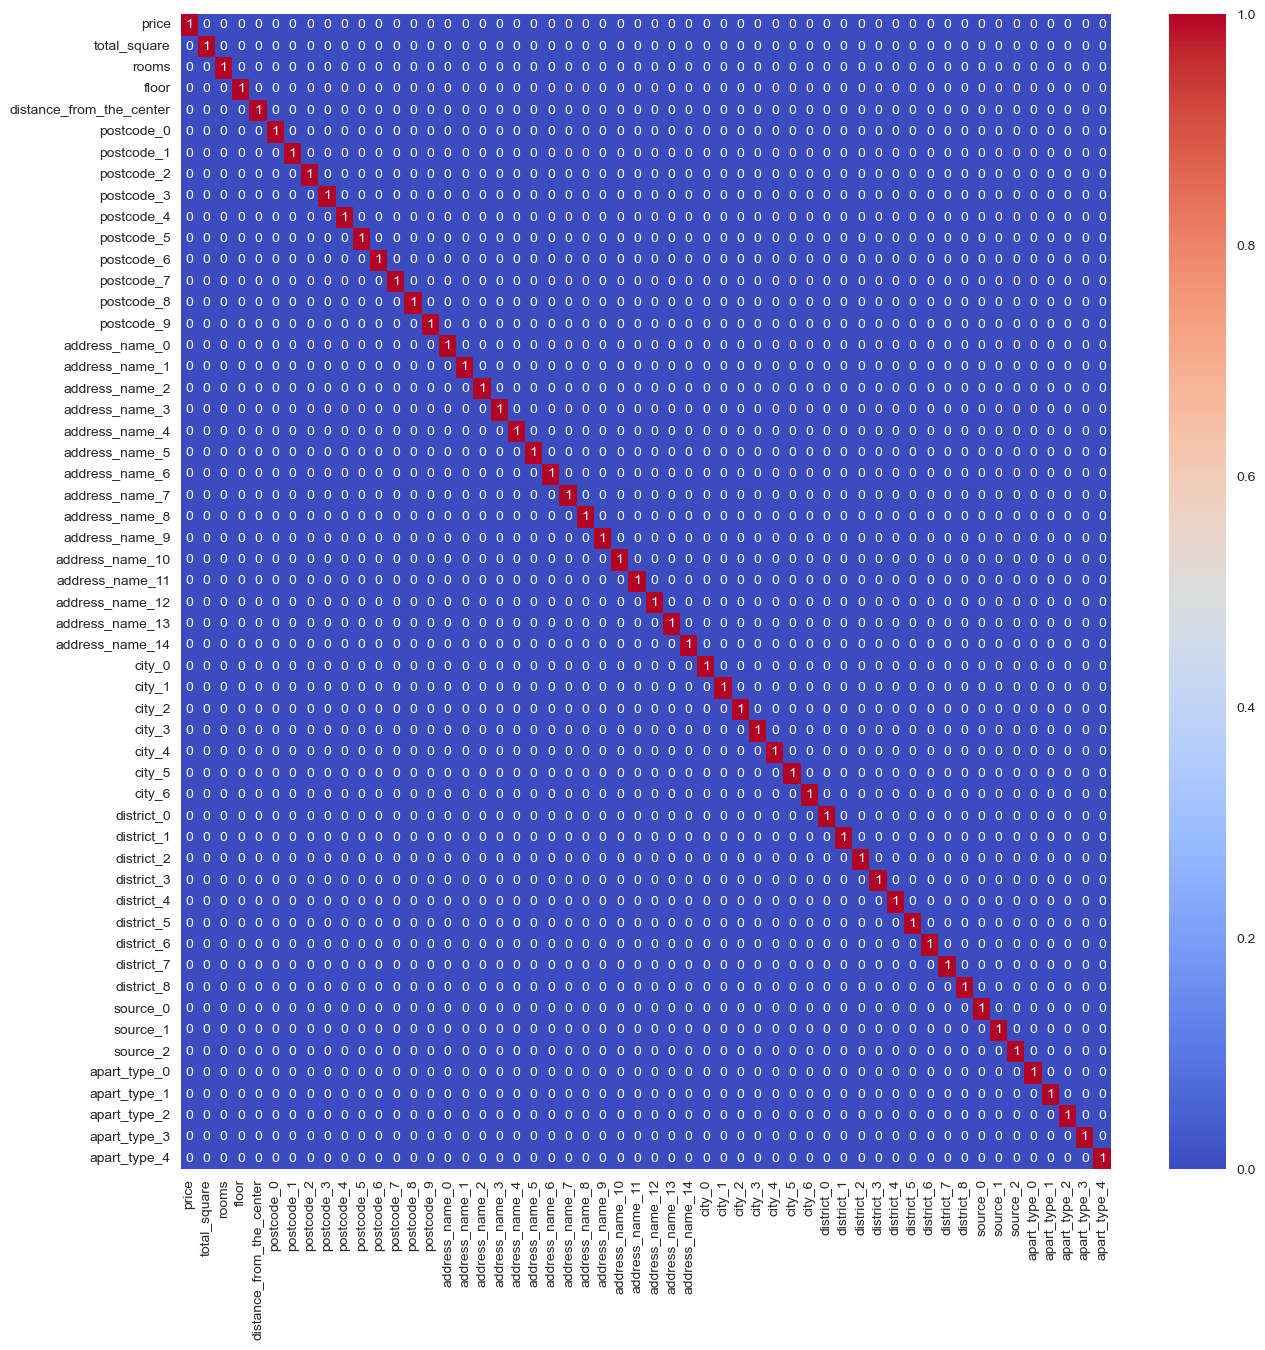

In [174]:
plt.rcParams['figure.figsize'] = (15,15)
sns.heatmap(data.corr() > 0.9, annot=True, cmap='coolwarm')

##### Мультикоррелированных признаков нет

##### 4.2. Оценим важность признаков 

<Axes: >

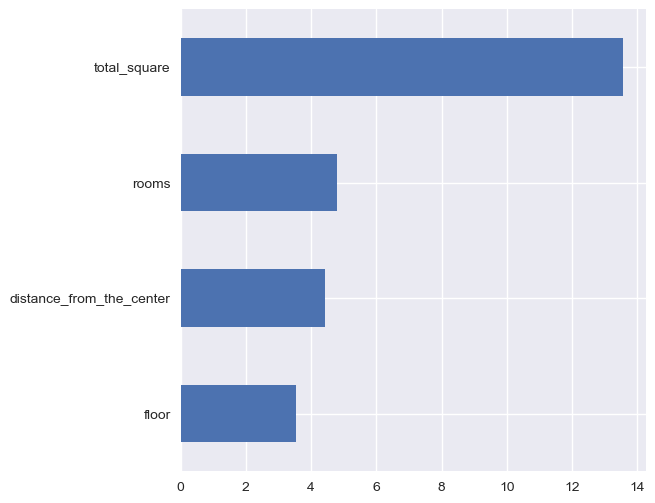

In [177]:
# Оценим значимость числовых признаков, используя тест ANOVA

from sklearn.feature_selection import f_classif

plt.rcParams['figure.figsize'] = (6,6)
importance_num = pd.Series(f_classif(data[nums_features_list], data['price'])[0], index = nums_features_list)
importance_num.sort_values(inplace = True)
importance_num.plot(kind = 'barh')

Предсказуемая картина

<Axes: >

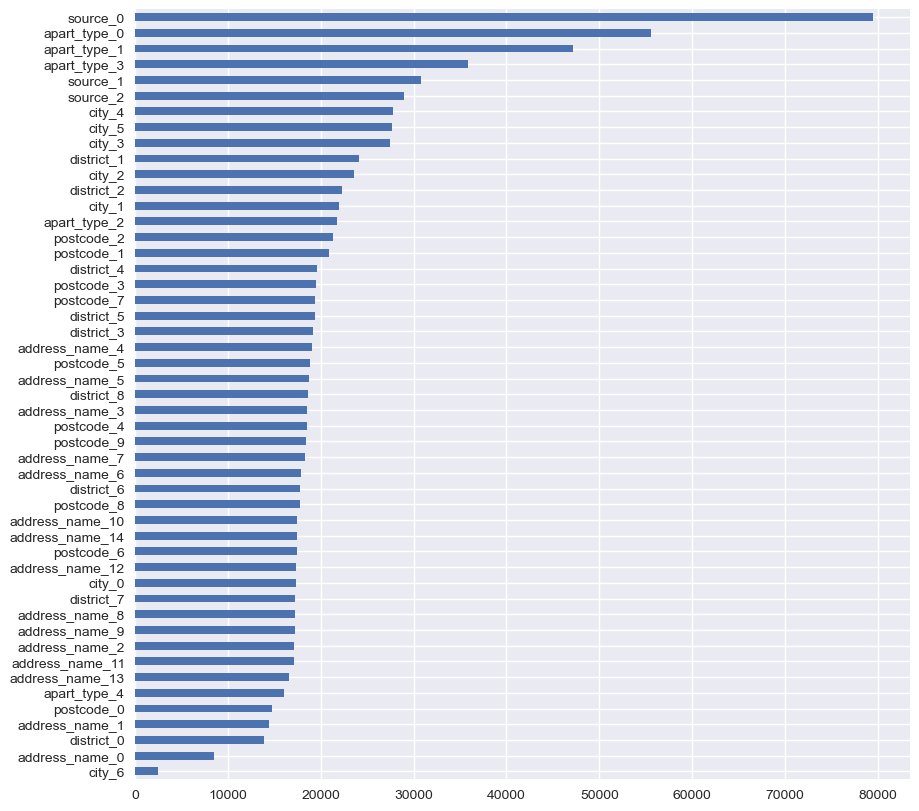

In [182]:
# Оценим значимость категориальных признаков, используя тест Хи-квадрат
from sklearn.feature_selection import chi2 

cat_features_list = data.columns.to_list()[5:]

plt.rcParams['figure.figsize'] = (10,10)
importance_cat = pd.Series(chi2(data[cat_features_list], data['price'])[0], index=cat_features_list)
importance_cat.sort_values(inplace = True)
importance_cat.plot(kind = 'barh')

На первой итерации оставим все признаки

#### 5. Пострение моделей

Предположения:  
Если оставить только числовые фичи и построить на них линейную регрессию возможно получится неплохая и очень легкая модель.  
Однако, будем оринетироваться на деревья решений, так как по моему предположению "деревянные модели" справятся с данной задачей лучше.

#### 5.1. TPOT

In [187]:
# Х - data, у - target

X = data.drop(['price'], axis=1)
y = data['price']

# train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(74116, 53) (24706, 53) (74116,) (24706,)


In [192]:
y


0         63000000
1          3250000
2         16004680
3          7841776
4        120000000
           ...    
98817     12183528
98818     34925000
98819     10000000
98820     15999000
98821     16750000
Name: price, Length: 98822, dtype: int64

TPOTRegressor в качестве метрики сравнения моделей использует MSE по уполчанию

In [191]:
from tpot import TPOTRegressor

tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

Version 0.11.7 of tpot is outdated. Version 0.12.1 was released 2 days ago.


Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -108984461830941.31

Generation 2 - Current best internal CV score: -108645018795684.78

Generation 3 - Current best internal CV score: -105414692943028.36

Generation 4 - Current best internal CV score: -98261388399268.33


TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RandomForestRegressor(SGDRegressor(input_matrix, alpha=0.01, eta0=0.01, fit_intercept=True, l1_ratio=0.5, learning_rate=constant, loss=epsilon_insensitive, penalty=elasticnet, power_t=10.0), bootstrap=True, max_features=0.5, min_samples_leaf=2, min_samples_split=3, n_estimators=100)


c:\Users\l-pla\anaconda3\envs\LI\lib\site-packages\sklearn\metrics\_scorer.py:794: FutureWarning: sklearn.metrics.SCORERS is deprecated and will be removed in v1.3. Please use sklearn.metrics.get_scorer_names to get a list of available scorers and sklearn.metrics.get_metric to get scorer.
  warnings.warn(
c:\Users\l-pla\anaconda3\envs\LI\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SGDRegressor was fitted with feature names
  warnings.warn(


-105225417262880.52
